<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-ml/blob/main/ES_ML_Cap%C3%ADtulo_06_Backtesting_Vectorizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>

# BackTesting Vectorizado
El backtesting es una parte esencial del trading. En efecto, es importante comprender el comportamiento de nuestra estrategia en el pasado para poder considerar los del futuro.

### Contenido

* Sortino Beta Alpha
* Drawdown 
* Crear la función BackTest para evaluar la estrategia en las secciones posteriores

</br>


💰 Únete a la comunidad de [Discord](https://discord.gg/wXjNPAc5BH)

📚 Puedes leer nuestro libro en [Amazon](https://www.amazon.com/gp/product/B09HG18CYL)

🖥️ El canal de [YouTube de Quantreo's](https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw) (en inglés) y el de [Frogames](https://www.youtube.com/channel/UCMUxXNYrVCv6-bQakhomvBg) en español

### Entorno

In [1]:
!pip install yfinance    
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=5a3fb47d2754d86567c0a4a2d4cc73b9d1a641b2fff4876c2a6d9ad4f16492e1
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import ta
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

# Sección 1: Sortino Beta Alpha

###### Sortino
El índice de Sortino es una estadística similar al índice de Sharpe con la misma interpretación. Sin embargo, el cálculo es ligeramente diferente. En efecto, en el índice de Sortino sólo se tiene en cuenta la volatilidad de las ganancias negativas porque es lo que tememos y no las ganancias alcistas que nos hacen ganar dinero. <br>
<p align="center">
$Sortino = \frac{\mu }{\sigma_{down}}$
<p> <br>

* SortinoRatio < 0 : Inversión no rentable porque las ganancias son negativas.
* SortinoRatio < 1: Inversión rentable, pero el riesgo de la inversión es mayor que la rentabilidad.
* SortinoRatio > 1: Inversión muy rentable porque el riesgo es menor que el rendimiento.


In [4]:
# Preparar los datos 
f = yf.download("GOOG", end="2021-01-01")
return_serie = f["Adj Close"].pct_change(1).dropna()

# Calcular el índice de Sortino
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #np.sqrt(252)
sortino = np.sqrt(252)*mean/vol

print(f"Sortino: {'%.3f' % sortino}")

[*********************100%***********************]  1 of 1 completed
Sortino: 1.232


###### Beta
La beta es un estadístico que indica la relación entre las variaciones de nuestra cartera y las del mercado que está representado por un índice (por ejemplo el SP500). <br>

<p align="center">
$Beta = \frac{Cov(r_{M},r_{PF}) }{Var(r_{M})}$
<p> <br>



* abs(Beta) < 1: Es bueno porque significa que la cartera tiene una variación menor que el índice. (Si beta=0,9 significa que si el índice varía en 1 la cartera varía en 0,9)
* abs(Beta) > 1: No es bueno porque significa que slau cartera tiene una variación mayor que el índice. (Si beta=1,1 significa que si el índice varía de 1 la cartera varía en 1,1)

*abs(-x) = x = abs(x) (abs da sólo el valor de la variable no el signo)*

In [5]:
# Necesitamos calcular la covarianza entre el mercado y la cartera 
sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
sp500.name = "SP500"

# Los concatenamos para hacer las covarianzas
val = pd.concat((return_serie, sp500), axis=1).dropna()
val

[*********************100%***********************]  1 of 1 completed


,Adj Close,SP500
Date,,
2004-08-20,0.079430,0.006525
2004-08-23,0.010064,-0.002431
2004-08-24,-0.041408,0.000465
2004-08-25,0.010775,0.008000
2004-08-26,0.018019,0.000118
...,...,...
2020-12-24,0.003735,0.003537
2020-12-28,0.021416,0.008723
2020-12-29,-0.009780,-0.002227


In [6]:
# Calculamos la matriz de covarianzas
cov_var_mat = np.cov(val.values, rowvar=False)
cov_var_mat

array([[0.00037086, 0.00014733],
       [0.00014733, 0.00015267]])

In [7]:
# Calculamos beta 
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

Beta: 0.965


###### **Alpha**
El alfa es una estadístico que indica si la cartera supera al mercado en términos de rentabilidad del riesgo. <br>

<p align="center">
$Alpha = r_{PF} - \beta*(r_{PF} - r_{f}) - r_{f}$
<p> <br>


* alfa > 0: La cartera supera al mercado en términos de rentabilidad del riesgo
* alfa < 0: la cartera tiene un rendimiento inferior al del mercado en términos de riesgo-rendimiento



In [8]:
# Calculamos alpha 
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha} %")

Alpha: 0.9 %


# Sección 2: Drawdown

El drawdown (reducción) es una medida del riesgo de la estrategia. Una estadística interesante para conocer el rendimiento del algoritmo es el drawdown máximo. En efecto, representa la pérdida máxima de una estrategia durante un período de tiempo que nos permite comprender si la estrategia es arriesgada y, por tanto, elegirla en función de nuestro nivel de aversión al riesgo.

In [9]:
def drawdown_function(serie):

  # Calculamos la suma de los rendimientos
  cum = serie.dropna().cumsum() + 1

  # Calculamos el máximo de la suma en el período (máximo acumulado) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # Calculamos el drawdown
  drawdown = cum/running_max - 1
  return drawdown

In [10]:
# Calculamos el drawdown
drawdown = drawdown_function(return_serie)
drawdown

Date
2004-08-20    0.000000
2004-08-23    0.000000
2004-08-24   -0.038006
2004-08-25   -0.028116
2004-08-26   -0.011578
                ...   
2020-12-24   -0.009246
2020-12-28   -0.005249
2020-12-29   -0.007074
2020-12-30   -0.009112
2020-12-31   -0.007786
Name: Adj Close, Length: 4121, dtype: float64

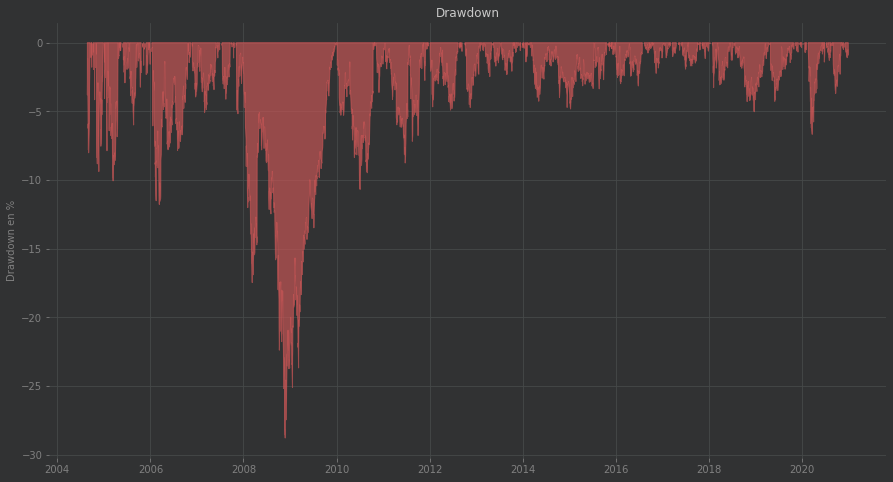

In [11]:
# Adaptar el tamaño de la figura
plt.figure(figsize=(15,8))

# Representar el drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# Añadimos el título
plt.title("Drawdown")

# Etiqueta del eje de la y
plt.ylabel("Drawdown en %")

plt.show()


In [12]:
# Cálculo del drawdown máximo
max_drawdown = -np.min(drawdown)*100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

Max drawdown: 28.8 %


# Sección 3: Crear la función BackTest para evaluar la estrategia en las secciones posteriores

In [13]:
def BackTest(serie, annualiazed_scalar=252):

  # Importar el benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Cambiar el nombre
  sp500.name = "SP500"

  # Concatenar los retornos y el sp500
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Calcular el drawdown
  drawdown = drawdown_function(serie)*100
  
  # Calcular el max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown en %", size=11)

  # Plot the graph
  plt.show()


  # Calcular el índice sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Calcular el índice  beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Calcular el índice  alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Imprimir los estadísticos
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

# Aplicación

In [15]:
import ta
def lin_reg_trading(symbol):

  def feature_engineering(df):
    """ Crear nuevas variables """
    
    # Copiamos el dataframe para evitar interferencias con los datos originales
    df_copy = df.dropna().copy()
    
    # Creamos el retorno
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Creamos las SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Calculamos las volatilidades
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Creamos el RSI
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    return df_copy.dropna()
  

  # Importar los datos
  df = yf.download(symbol)

  # Seleccionamos el valor de cierre ajustado
  df = df[["Adj Close"]]

  # Renombramos la columna
  df.columns = ["close"]

  dfc = feature_engineering(df)

  # Porcentaje de train/test
  split = int(0.80*len(dfc))

  # Creación del conjunto de training
  X_train = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[:split]
  y_train = dfc[["returns"]].iloc[:split]


  # Creación del conjunto de testing
  X_test = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[split:]
  y_test = dfc[["returns"]].iloc[split:]

  # Importar la clase
  from sklearn.linear_model import LinearRegression

  # Inicializar la clase
  reg = LinearRegression()

  # Ajustar el modelo
  reg.fit(X_train, y_train)

  # Creamos las predicciones para el conjunto de datos al completo
  X = np.concatenate((X_train, X_test), axis=0)

  dfc["prediction"] = reg.predict(X)

  # Calculamos la posición
  dfc["position"] = np.sign(dfc["prediction"])

  # Calculamos el retorno
  dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)

  dfc["return"] = dfc["strategy"]

  BackTest(dfc["return"].iloc[split:])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


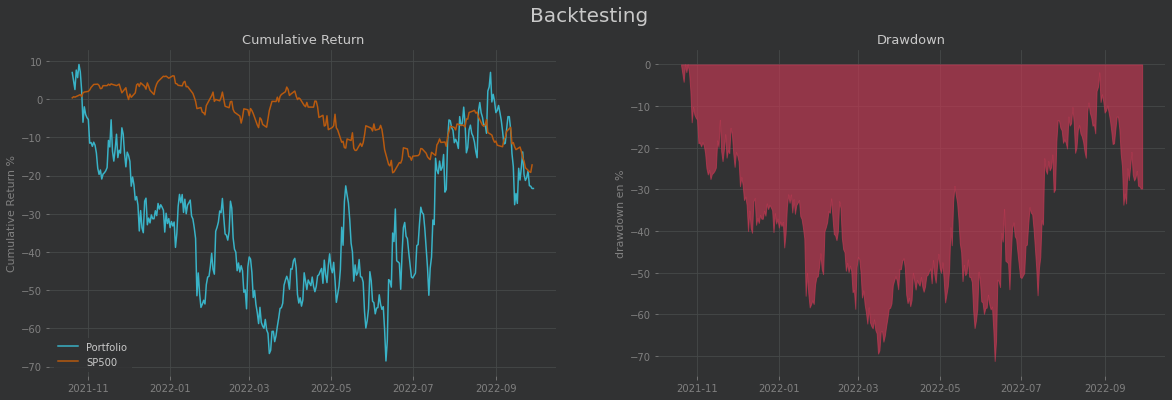

Sortino: -0.436
Beta: -0.107
Alpha: -18.888 %
MaxDrawdown: 71.158 %


In [20]:
lin_reg_trading("ETH-EUR")